In [127]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns
from scipy import stats

if os.name == "nt":
    plt.rcParams["font.family"] = "Meiryo"
elif os.name == "posix":
    plt.rcParams["font.family"] = "Hiragino Sans"

DATA = Path('../dataset').absolute()

# 時系列データの観察と要約

## 1.観察

- ボラティリティ:時系列データの変動の度合い

In [128]:
price4 = pd.read_csv(DATA / 'price4.csv',index_col=0)
rename_d = dict(
    x5202='旭硝子',
    x7272='ヤマハ',
    x4927='ポーラHD',
    x4502='武田薬品',
)
price4 = price4.rename(columns=rename_d)
price4.head()

,旭硝子,ヤマハ,ポーラHD,武田薬品
1,55,682,2460,3595
2,56,672,2543,3575
3,56,668,2544,3570
4,57,674,2500,3500
5,60,711,2535,3545


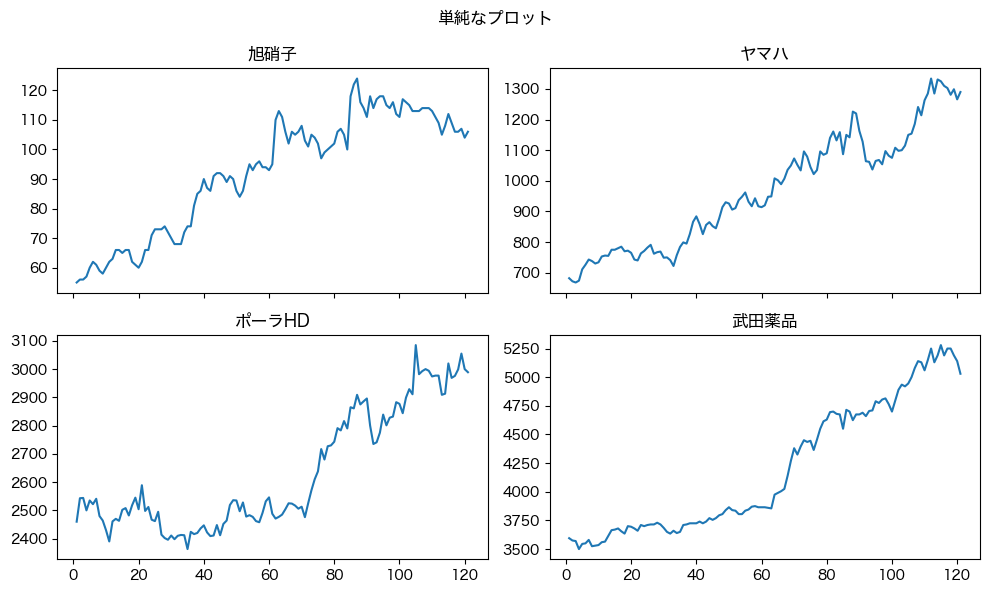

In [129]:
fig, axes = plt.subplots(
    ncols=2,
    nrows=2,
    figsize = (10,6),
    tight_layout = True,
    sharex=True,
    sharey=False,
)
axes = np.ravel(axes)

for col,ax in zip(price4.columns,axes):
    ax.plot(price4.index,price4[col])
    ax.set_title(col)
fig.suptitle(('単純なプロット'))
plt.show()

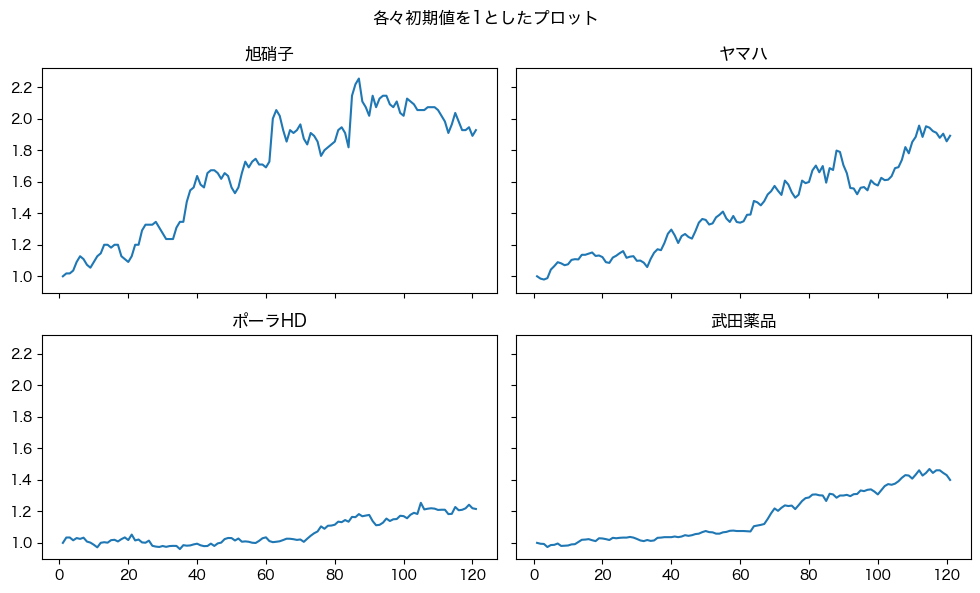

In [130]:
fig, axes = plt.subplots(
    ncols=2,
    nrows=2,
    figsize = (10,6),
    tight_layout = True,
    sharex=True,
    sharey=True,
)
axes = np.ravel(axes)

for col,ax in zip(price4.columns,axes):
    ar = price4[col].values
    scaled_ar = ar / ar[0]
    ax.plot(price4.index,scaled_ar)
    ax.set_title(col)
fig.suptitle(('各々初期値を1としたプロット'))
plt.show()

- 対数差収益率
  - $r_i = \log{P_t} - \log{P_{t-1}} = \log{\frac{P_t}{P_{t-1}}}$

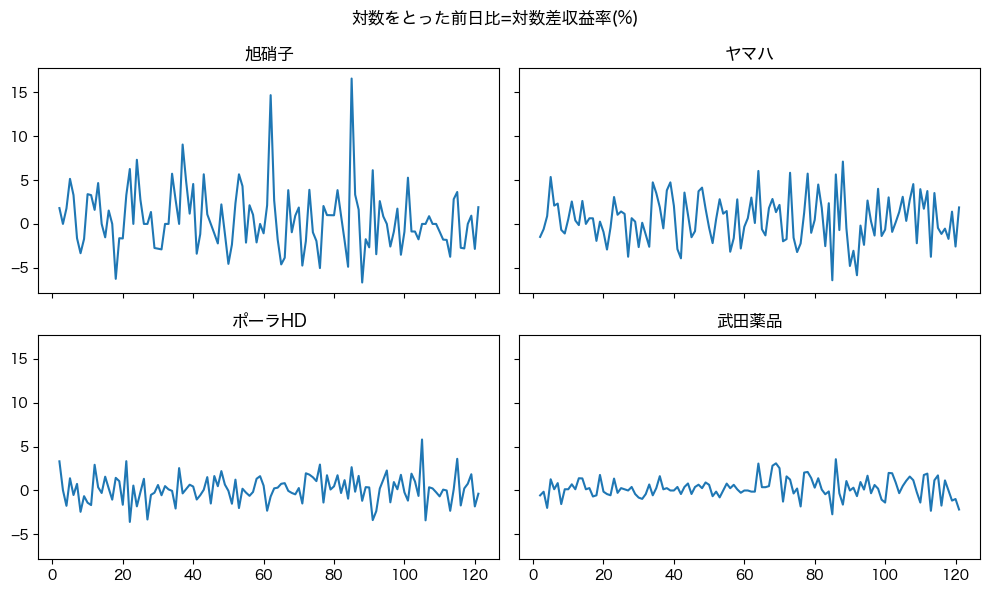

In [131]:
fig, axes = plt.subplots(
    ncols=2,
    nrows=2,
    figsize = (10,6),
    tight_layout = True,
    sharex=True,
    sharey=True,
)
axes = np.ravel(axes)

for col,ax in zip(price4.columns,axes):
    ar = price4[col].values
    log_rate_ar = np.diff(np.log(ar))
    ax.plot(price4.index[1:],log_rate_ar*100)
    ax.set_title(col)
fig.suptitle(('対数をとった前日比=対数差収益率(%)'))
plt.show()

前日比をとることでボラティリティを可視化できる

### Q.なぜ対数差収益率などというよくわからない値を使うのか？そしてこれを%表示にできるのか？

A. 以下の2つの理由から対数差収益率を使う利点があるから。また、多くの金融理論が対数差収益率に基づいて成り立っているから

1. 収益率が0に近しいとき近似的に対数差収益率と収益率は一致する
2. 価格変動が幾何ブラウン過程(確率過程の一種)に従うと仮定すると、対数差収益率は正規分布に従うと仮定することができる

1.についての数学的な証明
$$
\begin{align*}
ある時刻tにおける収益率R_tを以下のように定義する \\
R_t = \frac{S_t - S_{t-1}}{S_{t-1}} \\
x=0近傍でのテーラー展開より、\log(1+x) \sim xが成り立つ \\
これより、R_t \sim \log(1+R_t) = \log(\frac{S_{t-1}}{S_{t-1}} + \frac{S_t - S_{t-1}}{S_{t-1}}) = \log(\frac{S_t}{S_{t-1}}) \\
上記より、xが0の近傍の時、R_t \sim \log(\frac{S_t}{S_{t-1}})
\end{align*}
$$

## 2.分布と要約

統計量を算出して比較議論するために、母集団分布を仮定する。  
一般に、サンプルサイズが増えるほど標本分布は母集団分布に近づくが、それは同一分布からの独立標本であるという仮定が必要。  
時系列データの場合、サンプルサイズを増やすために期間を長くとると、その期間内に状況が変わる(同一の母集団分布からの標本だと見做せなくなる)リスクが増えるため、期間を長くとってサンプルサイズを稼ぐよりは、同一母集団であると仮定ができるくらいの期間にして限られたサンプルサイズで分析を実施することが多いとのこと。

In [132]:
return4 = pd.DataFrame(
    data=np.diff((np.log(price4)),axis=0)*100,
    columns=rename_d.values()
)

一旦、対数差収益率は正規分布に従うと仮定してデータを見てみる。

In [133]:
return4.describe()

,旭硝子,ヤマハ,ポーラHD,武田薬品
count,120.000000,120.000000,120.000000,120.000000
mean,0.546755,0.531140,0.162315,0.279897
std,3.565816,2.638556,1.546933,1.133956
min,-6.669137,-6.413596,-3.578129,-2.710193
25%,-1.785762,-1.309304,-0.624143,-0.352904
50%,0.000000,0.372419,0.153384,0.141643
75%,2.254998,2.406774,1.095011,0.927286
max,16.551444,7.097573,5.805499,3.562168


ボラティリティの指標の一つである標準偏差を見ると、旭硝子はダントツで乱高下しやすいことがわかる。

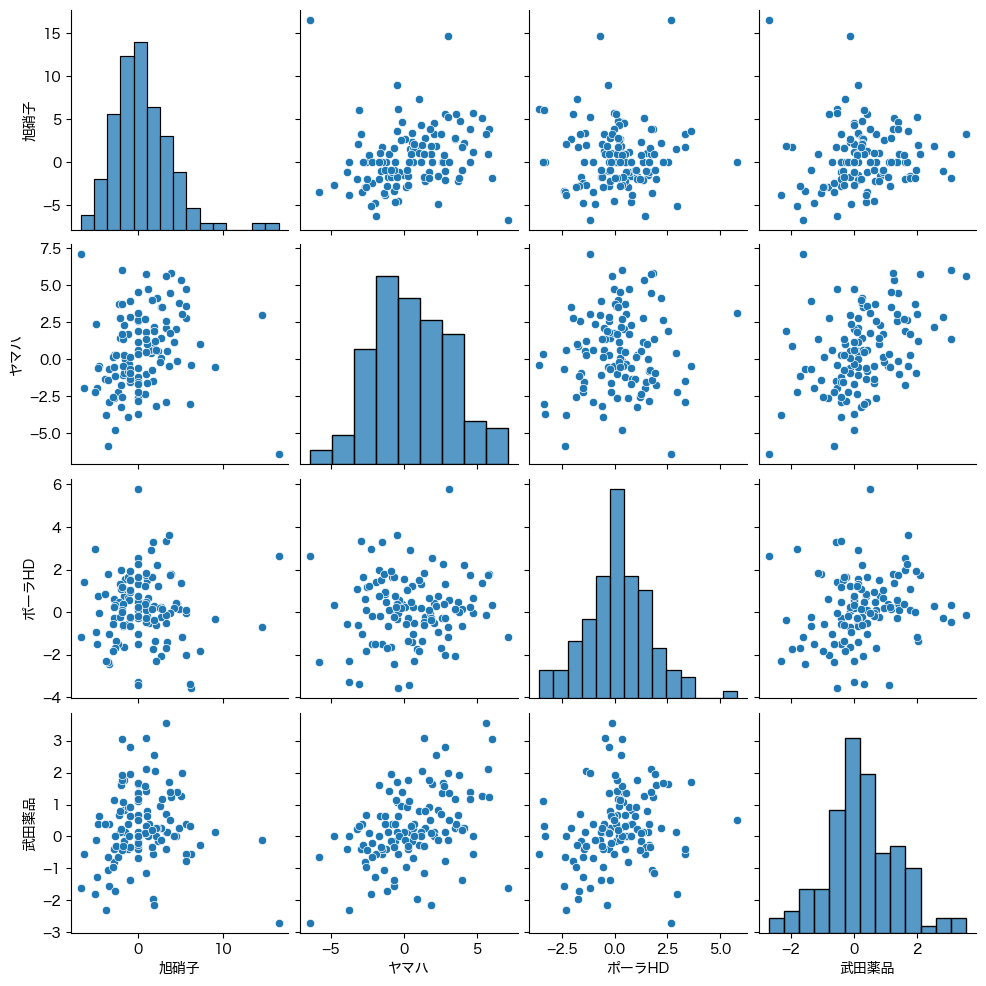

In [134]:
sns.pairplot(return4)
plt.show()

<Axes: >

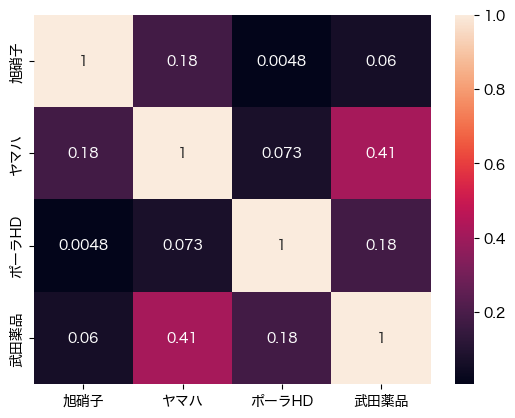

In [135]:
sns.heatmap(return4.corr(),annot=True)

- 目視レベルでは旭硝子の分布は右裾が重く、武田は尖度が大きそう
- ヤマハと武田薬品の相関がやや高い


ここまで、ひとまず対数差収益率が独立に同一な正規分布に従う仮定を置いたが、果たして本当にそう見做せるのか？
1. Shapiro-wilk test
   - 与えられたサンプルが正規分布に従うかどうかの検定
   - 帰無仮説=正規分布に従う
     - つまり、一定の統計的優位性をもって「正規分布に従っていない」ということは積極的に言えるが、p値が危険水準αを上回った場合でも「正規分布に従っていない**とは言えない**」という消極的な結論になる
2. runs test
   - データ列がランダムな順序で並んでいるかどうかを調べる検定
   - 本来は2値データの順序についてだが、"ある値"(例えば中央値)よりも大きいデータ・小さいデータと分けて２値化して連続値データの並びのランダムネスの評価にも用いられる
   - 帰無仮説：データはランダムである
     - つまり、一定の統計的優位性をもって「データがランダムでない」ということは積極的に言えるが、p値が危険水準αを上回った場合でも「データがランダムでない**とは言えない**」という消極的な結論になる

In [136]:
def runs_test(data):
    """
    連の検定を行う関数
    Args:
        data (list or numpy.ndarray): 検定対象のデータ列
    Returns:
        tuple: (Z値, p値)
    """
    # データを二値化（中央値より大きい場合1、小さい場合0）
    median = np.median(data)
    binary_data = [1 if x > median else 0 for x in data]
    # 連の数を数える
    runs = 1
    for i in range(1, len(binary_data)):
        if binary_data[i] != binary_data[i - 1]:
            runs += 1

    # 各記号の数を数える
    n1 = sum(binary_data)
    n2 = len(binary_data) - n1

    # 期待値と分散を計算
    expected_runs = (2 * n1 * n2) / (n1 + n2) + 1
    variance = (2 * n1 * n2 * (2 * n1 * n2 - n1 - n2)) / ((n1 + n2) ** 2 * (n1 + n2 - 1))

    # Z値を計算
    z_value = (runs - expected_runs) / np.sqrt(variance)

    # p値を計算
    p_value = 2 * (1 - stats.norm.cdf(abs(z_value)))

    return z_value, p_value

# サンプルデータ
data = [1, 2, 3, 1, 2, 4, 5, 2, 1, 3, 4, 5, 6, 7, 8, 2, 3, 1, 2, 3]

# 連の検定を実行
z, p = runs_test(data)

# 結果を出力
print("Z値:", z)
print("p値:", p)

# 結果の判定
alpha = 0.05  # 有意水準
if p < alpha:
    print("データ列はランダムではない（有意水準", alpha, "）")
else:
    print("データ列はランダムでないとは言えない（有意水準", alpha, "）")

data = np.random.choice(data,size=len(data))
# 連の検定を実行
z, p = runs_test(data)

# 結果を出力
print("Z値:", z)
print("p値:", p)

# 結果の判定
alpha = 0.05  # 有意水準
if p < alpha:
    print("データ列はランダムではない（有意水準", alpha, "）")
else:
    print("データ列はランダムでないとは言えない（有意水準", alpha, "）")

Z値: -2.589308344812897
p値: 0.009616893905388446
データ列はランダムではない（有意水準 0.05 ）
Z値: 0.1918898262711097
p値: 0.8478285068142399
データ列はランダムでないとは言えない（有意水準 0.05 ）


In [137]:
w,p=stats.shapiro(data)

In [138]:
alpha = 0.05  # 有意水準

for col in return4.columns:
    print(f"--{col}----------")
    data = return4[col].values
    w,p = stats.shapiro(data)
    if p < alpha:
        print(f"  データは正規分布に従わない (p:{p:.1%} < 有意水準{alpha:.0%})")
    else:
        print(f"  データ列は正規分布に従いそう (p:{p:.1%} >= 有意水準{alpha:.0%})")
    z,p = runs_test(data)
    if p < alpha:
        print(f"  データ列はランダムではない (p:{p:.1%} < 有意水準{alpha:.0%})")
    else:
        print(f"  データ列はランダムっぽい (p:{p:.1%} >= 有意水準{alpha:.0%})")

--旭硝子----------
  データは正規分布に従わない (p:0.0% < 有意水準5%)
  データ列はランダムっぽい (p:17.1% >= 有意水準5%)
--ヤマハ----------
  データ列は正規分布に従いそう (p:94.8% >= 有意水準5%)
  データ列はランダムっぽい (p:85.5% >= 有意水準5%)
--ポーラHD----------
  データ列は正規分布に従いそう (p:14.2% >= 有意水準5%)
  データ列はランダムっぽい (p:9.9% >= 有意水準5%)
--武田薬品----------
  データ列は正規分布に従いそう (p:18.9% >= 有意水準5%)
  データ列はランダムっぽい (p:46.3% >= 有意水準5%)


旭硝子は正規分布に従わないし、ポーラの順番は有意水準いかんによってはランダムでないと判定される可能性がある。  
実際問題時系列のデータは、例えば株価なら上がってる時は上がり続けるし下がっている時は下がり続ける、という特性があり、時間に依存した構造になっているのがほぼほぼ自明ではある。  
**うっかりヒストグラムだけ書いて得られたデータが釣鐘型だから正規分布〜と安易に決めてはいけない**。  
時間依存がある場合は**独立なサンプリング**だと言えない！

In [156]:
np.sqrt(5)

np.float64(2.23606797749979)

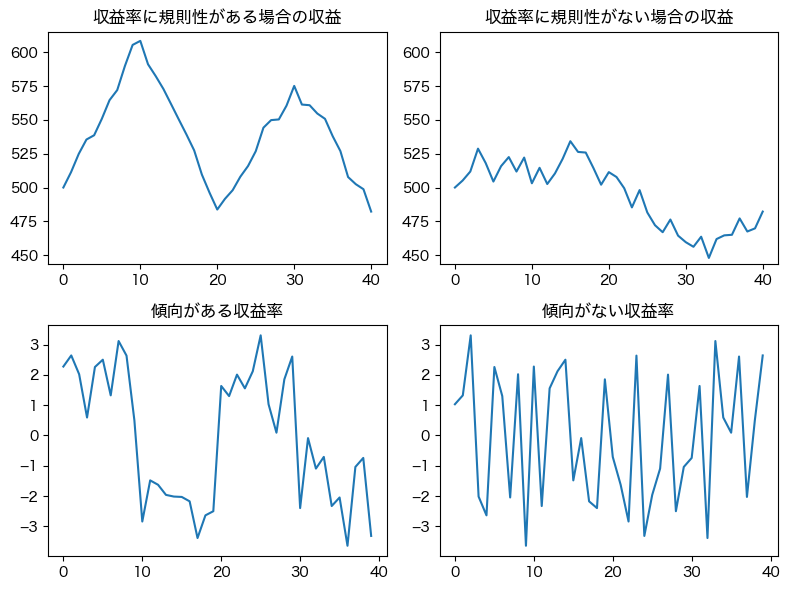

In [167]:
def price_from_return(initial_price,return_ar):
    price = [initial_price]
    for ret in return_ar:
        next = price[-1]*(1+ret/100)
        price.append(next)
    return price

# x:収益率の変動に規則性がある場合の価格変動
x_return = np.hstack([
    stats.norm.rvs(loc=2,scale=1, size=10),
    stats.norm.rvs(loc=-2,scale=1, size=10),
    stats.norm.rvs(loc=2,scale=1, size=10),
    stats.norm.rvs(loc=-2,scale=1, size=10),
])
x_price = price_from_return(500,x_return)

# y:収益率の変動に規則性がない場合の価格変動
y_return = np.random.permutation(x_return)
y_price = price_from_return(500,y_return)


fig, axes = plt.subplots(
    ncols=2,
    nrows=2,
    figsize = (8,6),
    tight_layout = True,
)

data = [[x_price,y_price],[x_return,y_return]]
name = [["収益率に規則性がある場合の収益","収益率に規則性がない場合の収益"],["傾向がある収益率","傾向がない収益率"]]

for da,na,axe in zip(data,name,axes):
    miny = 999999
    maxy = 0
    for d,n,ax in zip(da,na,axe):
        ax.plot(d)
        ax.set_title(n)
        min,max = ax.get_ylim()
        if min <= miny:
            miny = min
        if max >= maxy:
            maxy = max
    for ax in axe:
        ax.set_ylim(miny,maxy)
